In [1]:
import os
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
head = "KITTI/data_scene_flow/training"

In [3]:
os.listdir(head)

['image_3',
 'disp_occ_1',
 'disp_noc_1',
 'viz_flow_occ_dilate_1',
 'viz_flow_occ',
 'disp_noc_0',
 'obj_map',
 'image_2',
 'flow_occ',
 'disp_occ_0',
 'flow_noc']

In [4]:
image_2_paths = sorted([os.path.join(head, "image_2", x) for x in os.listdir(head + "/image_2")])
image_3_paths = sorted([os.path.join(head, "image_3", x) for x in os.listdir(head + "/image_3")])
flow_paths = sorted([os.path.join(head, "flow_occ", x) for x in os.listdir(head + "/flow_occ")])

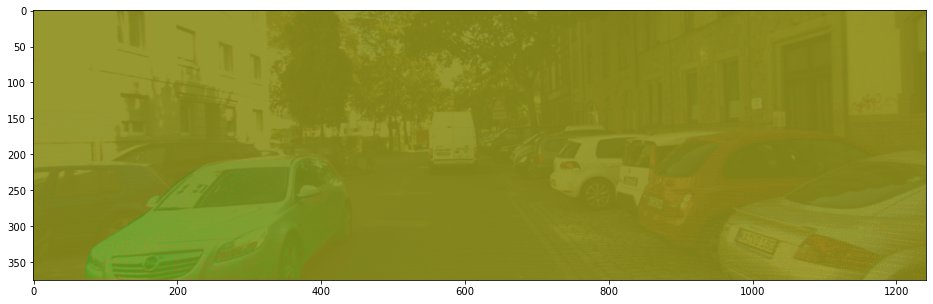

In [5]:
i = 6
plt.figure(figsize=(16, 16))
plt.imshow(Image.open(flow_paths[i]), alpha=0.9)
plt.imshow(Image.open(image_2_paths[i * 2]), alpha=0.1)

In [6]:
#image_paths = 

In [7]:
test_size = 0.4
np.random.choice

<function RandomState.choice>

In [8]:
class KITTIData(torch.utils.data.Dataset):
    def __init__(self, image_path="image_2", flow_path="flow_occ"):
        super().__init__()
        head = "KITTI/data_scene_flow/training"
        self.image_paths = sorted([os.path.join(head, image_path, x) for x in os.listdir(os.path.join(head, image_path))])
        self.flow_paths = sorted([os.path.join(head, flow_path, x) for x in os.listdir(os.path.join(head, flow_path))])
        
        assert len(self.image_paths) == len(self.flow_paths) * 2
        
        self.images = []
        self.flows = []
        for i in range(len(self.image_paths)):
            self.images.append(Image.open(self.image_paths[i]))
        for i in range(len(self.flow_paths)):
            self.flows.append(Image.open(self.flow_paths[i]))
            
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((375, 1242)),
            torchvision.transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.flow_paths)
        
    def __getitem__(self, i):
        first = self.transforms(self.images[i * 2])
        second = self.transforms(self.images[(i * 2) + 1])
        together = torch.cat((first, second), dim=0)
        label = self.transforms(self.flows[i])[:2, :, :]
        return together, label
        

In [10]:
dataset = KITTIData()

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
a = next(iter(dataloader))

In [12]:
epochs = 10
lr = 1e-3

In [13]:
from model import flownets, FlowNetS
from multiscaleloss import multiscaleEPE
model = FlowNetS() #insert model here
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #insert optimizer here
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = torch.nn.MSELoss()

/home/ubuntu/cs231n/util.py:12: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  "which is needed for FlowNetC", ImportWarning)


In [14]:
model.to(device)

FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leaky

In [15]:
losses = []

for epoch in range(epochs):
    
    print("Epoch", str(epoch) + ": ", end="")
    epoch_loss = 0.0
    
    for i, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        # outputs = model.forward(image)[0]
        outputs = model(image)
        h, w = label.size()[-2:]
        outputs = [torch.nn.functional.interpolate(outputs[0], (h,w)), *outputs[1:]]
        
        # loss = loss_fn(outputs, label)
        loss = multiscaleEPE(outputs, label, sparse=True)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print("Loss:", epoch_loss)
    losses.append(epoch_loss)

Epoch 0: Loss: 26325.600830078125
Epoch 1: Loss: 6870.6688232421875
Epoch 2: Loss: 3796.9497985839844
Epoch 3: Loss: 2725.9161071777344
Epoch 4: Loss: 2616.5811157226562
Epoch 5: Loss: 2227.1627807617188
Epoch 6: Loss: 2065.493408203125
Epoch 7: Loss: 1811.8579406738281
Epoch 8: Loss: 1759.9928283691406
Epoch 9: Loss: 1835.2706146240234


In [28]:
def show_prediction():
    viz_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    batch = next(iter(viz_loader))
    tensor = batch[0]
    label = batch[1]
    model.eval()
    out = model(tensor.to(device))
    output = torch.nn.functional.interpolate(out, size=label.shape[-2:], mode="bilinear", align_corners=False)
    output = output.squeeze()
    label = label.squeeze()
    prediction = np.concatenate((output.detach().cpu().numpy(), np.zeros([1] + list(output.shape[-2:]))), axis=0)
    label = np.concatenate((label.detach().cpu().numpy(), np.zeros([1] + list(output.shape[-2:]))), axis=0)
    img = torch.split(tensor,3, dim=1)[0].squeeze()

    plt.figure(figsize=(18, 18))
    plt.imshow(np.transpose(prediction, (1, 2, 0)), alpha=0.7)
    #plt.imshow(np.transpose(img, (1, 2, 0)), alpha=0.3)

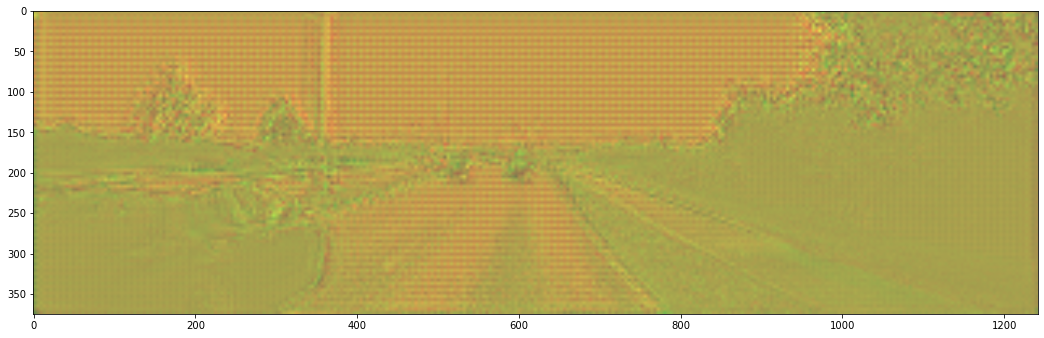

In [31]:
show_prediction()